In [30]:
import os
import numpy as np
from scipy import stats

import torch

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.face_detection import get_fair_face, get_utk
from source.utils.metrics import accuracy, aod, eod, spd, get_prs, get_tprs, get_fprs

os.makedirs(PLOTS_PATH, exist_ok=True)

In [31]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

model = ["resnet18", "resnet34", "resnet50", "regnet", "efficientnet", "efficientnet_mcdropout"][2]

targets = ["age", "gender", "race (old)", "race"]
# predicting race does not give high unfairness (with either pa) for eod and aod
# predicting gender also not too nice (only unfairness with age)
target = 0 # 0, 1, 2, 3
pa = 1 # 0, 1, 2, 3

In [32]:
# no need to define targets and protected attributes, are queried directly afterwards
ff_train_ds, ff_test_ds = get_fair_face(binarize=True, augment=False)
utk_test_ds = get_utk(binarize=True)

run_path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds), len(ff_test_ds), len(utk_test_ds))

# get targets and protected attributes
y_fair_t = ff_train_ds.targets[target, fair_inds]
a_fair_t = ff_train_ds.targets[pa, fair_inds]
y_val_t = ff_train_ds.targets[target, val_inds]
a_val_t = ff_train_ds.targets[pa, val_inds]
y_ff_test_t = ff_test_ds.targets[target]
a_ff_test_t = ff_test_ds.targets[pa]
y_utk_test_t = utk_test_ds.targets[target]
a_utk_test_t = utk_test_ds.targets[pa]

# get fraction of protected attribute for testsets
p_a_ff_test = a_ff_test_t.float().mean().item() * 100
p_a_utk_test = a_utk_test_t.float().mean().item() * 100
print(p_a_ff_test, p_a_utk_test)

# get fraction of targets for testsets
p_y_ff_test = y_ff_test_t.float().mean().item() * 100
p_y_utk_test = y_utk_test_t.float().mean().item() * 100
print(p_y_ff_test, p_y_utk_test)

/system/user/publicwork/kschweig/disparate-benefits/source/data/face_detection.py:117: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gender'].replace(gender_dict, inplace=True)
/system/user/publicwork/kschweig/disparate-benefits/source/data/face_detection.py:117: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

10843 10843 10954 23705
52.875661849975586 52.27167010307312
44.896841049194336 55.19510507583618


In [33]:
# load probits
fair_probits, val_probits, ff_test_probits, utk_test_probits = list(), list(), list(), list()
for mseed in method_seeds:
    path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{mseed}_dseed{dseed}")

    fair_probits.append(torch.load(os.path.join(path, f"fair_probits_t{target}.pt")))
    val_probits.append(torch.load(os.path.join(path, f"val_probits_t{target}.pt")))
    ff_test_probits.append(torch.load(os.path.join(path, f"ff_test_probits_t{target}.pt")))
    utk_test_probits.append(torch.load(os.path.join(path, f"utk_test_probits_t{target}.pt")))

In [34]:
# calculate accuracies and fairness measures
fair_accs, val_accs, ff_test_accs, utk_test_accs = list(), list(), list(), list()
fair_spds, val_spds, ff_test_spds, utk_test_spds = list(), list(), list(), list()
fair_eods, val_eods, ff_test_eods, utk_test_eods = list(), list(), list(), list()
fair_aods, val_aods, ff_test_aods, utk_test_aods = list(), list(), list(), list()

for m in range(len(method_seeds)):
    fair_accs.append([accuracy(p.argmax(dim=1), y_fair_t) for p in fair_probits[m]])
    val_accs.append([accuracy(p.argmax(dim=1), y_val_t) for p in val_probits[m]])
    ff_test_accs.append([accuracy(p.argmax(dim=1), y_ff_test_t) for p in ff_test_probits[m]])
    utk_test_accs.append([accuracy(p.argmax(dim=1), y_utk_test_t) for p in utk_test_probits[m]])

    fair_spds.append([spd(p.argmax(dim=1), a_fair_t) for p in fair_probits[m]])
    val_spds.append([spd(p.argmax(dim=1), a_val_t) for p in val_probits[m]])
    ff_test_spds.append([spd(p.argmax(dim=1), a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_spds.append([spd(p.argmax(dim=1), a_utk_test_t) for p in utk_test_probits[m]])
    
    fair_eods.append([eod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_eods.append([eod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])
    ff_test_eods.append([eod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_eods.append([eod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

    fair_aods.append([aod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_aods.append([aod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])
    ff_test_aods.append([aod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_aods.append([aod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

In [35]:
ff_test_m_accs, utk_test_m_accs = list(), list()
ff_test_m_spds, utk_test_m_spds = list(), list()
ff_test_m_eods, utk_test_m_eods = list(), list()
ff_test_m_aods, utk_test_m_aods = list(), list()

for m in range(len(method_seeds)):
    ff_test_m_accs.append(accuracy(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t))
    utk_test_m_accs.append(accuracy(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t))

    ff_test_m_spds.append(spd(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), a_ff_test_t))
    utk_test_m_spds.append(spd(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), a_utk_test_t))
    
    ff_test_m_eods.append(eod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
    utk_test_m_eods.append(eod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

    ff_test_m_aods.append(aod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
    utk_test_m_aods.append(aod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

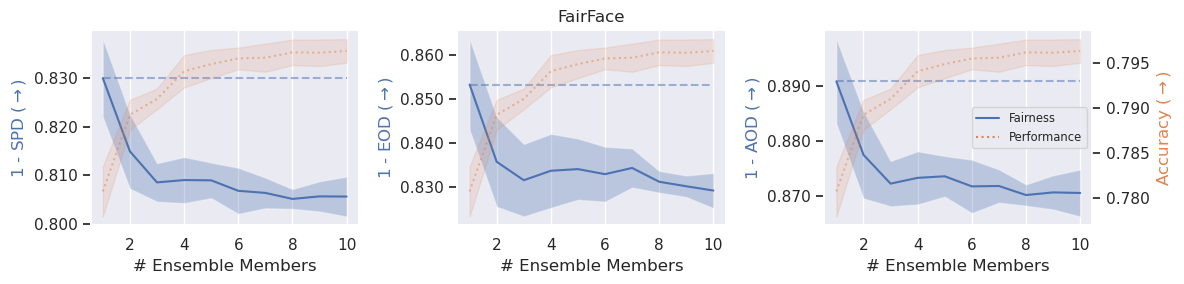

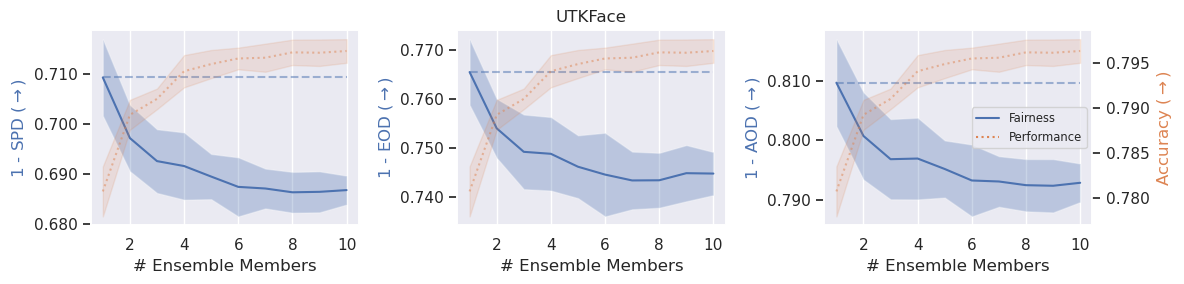

In [36]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

ff_test_fm_accs, utk_test_fm_accs = list(), list()
ff_test_fm_spds, utk_test_fm_spds = list(), list()
ff_test_fm_eods, utk_test_fm_eods = list(), list()
ff_test_fm_aods, utk_test_fm_aods = list(), list()

for m in range(len(method_seeds)):

    ff_test_fm_accs_, utk_test_fm_accs_ = list(), list()
    ff_test_fm_spds_, utk_test_fm_spds_ = list(), list()
    ff_test_fm_eods_, utk_test_fm_eods_ = list(), list()
    ff_test_fm_aods_, utk_test_fm_aods_ = list(), list()

    for em in ensemble_members:
        preds = torch.mean(ff_test_probits[m][:em], dim=0).argmax(dim=1)
        ff_test_fm_accs_.append(accuracy(preds, y_ff_test_t))
        ff_test_fm_spds_.append(1 - spd(preds, a_ff_test_t))
        ff_test_fm_eods_.append(1 - eod(preds, y_ff_test_t, a_ff_test_t))
        ff_test_fm_aods_.append(1 - aod(preds, y_ff_test_t, a_ff_test_t))

        preds = torch.mean(utk_test_probits[m][:em], dim=0).argmax(dim=1)
        utk_test_fm_accs_.append(accuracy(preds, y_utk_test_t))
        utk_test_fm_spds_.append(1 - spd(preds, a_utk_test_t))
        utk_test_fm_eods_.append(1 - eod(preds, y_utk_test_t, a_utk_test_t))
        utk_test_fm_aods_.append(1 - aod(preds, y_utk_test_t, a_utk_test_t))

    ff_test_fm_accs.append(ff_test_fm_accs_)
    utk_test_fm_accs.append(utk_test_fm_accs_)
    ff_test_fm_spds.append(ff_test_fm_spds_)
    utk_test_fm_spds.append(utk_test_fm_spds_)
    ff_test_fm_eods.append(ff_test_fm_eods_)
    utk_test_fm_eods.append(utk_test_fm_eods_)
    ff_test_fm_aods.append(ff_test_fm_aods_)
    utk_test_fm_aods.append(utk_test_fm_aods_)

ff_test_fm_accs = np.asarray(ff_test_fm_accs)
utk_test_fm_accs = np.asarray(utk_test_fm_accs)
ff_test_fm_spds = np.asarray(ff_test_fm_spds)
utk_test_fm_spds = np.asarray(utk_test_fm_spds)
ff_test_fm_eods = np.asarray(ff_test_fm_eods)
utk_test_fm_eods = np.asarray(utk_test_fm_eods)
ff_test_fm_aods = np.asarray(ff_test_fm_aods)
utk_test_fm_aods = np.asarray(utk_test_fm_aods)


# FairFace Plotting
acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(ff_test_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                   np.mean(ff_test_fm_spds, axis=0) - np.std(ff_test_fm_spds, axis=0), 
                   np.mean(ff_test_fm_spds, axis=0) + np.std(ff_test_fm_spds, axis=0), alpha=0.3)
axs[0].hlines(np.mean(ff_test_fm_spds, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("1 - SPD ($\\rightarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(ff_test_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members,
                   np.mean(ff_test_fm_eods, axis=0) - np.std(ff_test_fm_eods, axis=0), 
                   np.mean(ff_test_fm_eods, axis=0) + np.std(ff_test_fm_eods, axis=0), alpha=0.3)
axs[1].hlines(np.mean(ff_test_fm_eods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("1 - EOD ($\\rightarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(ff_test_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members,
                   np.mean(ff_test_fm_aods, axis=0) - np.std(ff_test_fm_aods, axis=0), 
                   np.mean(ff_test_fm_aods, axis=0) + np.std(ff_test_fm_aods, axis=0), alpha=0.3)
axs[2].hlines(np.mean(ff_test_fm_aods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("1 - AOD ($\\rightarrow$)", color="C0")

axs[1].set_title("FairFace")

for ax in axs:
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    ax.plot(ensemble_members, np.mean(utk_test_fm_accs, axis=0), ":", c="C1", alpha=0.5)
    ax.fill_between(ensemble_members, 
                    np.mean(utk_test_fm_accs, axis=0) - np.std(utk_test_fm_accs, axis=0), 
                    np.mean(utk_test_fm_accs, axis=0) + np.std(utk_test_fm_accs, axis=0), alpha=0.15, color="C1")
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

handle_1 = mlines.Line2D([], [], color='C0', linestyle="solid", label='Fairness')
handle_2 = mlines.Line2D([], [], color='C1', linestyle="dotted", label='Performance')
axs[2].legend(handles=[handle_1, handle_2], loc="center right", fontsize="x-small")
f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_ff.pdf"))
plt.show()

# UTKFace Plotting
acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(utk_test_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                   np.mean(utk_test_fm_spds, axis=0) - np.std(utk_test_fm_spds, axis=0), 
                   np.mean(utk_test_fm_spds, axis=0) + np.std(utk_test_fm_spds, axis=0), alpha=0.3)
axs[0].hlines(np.mean(utk_test_fm_spds, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("1 - SPD ($\\rightarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(utk_test_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members,
                   np.mean(utk_test_fm_eods, axis=0) - np.std(utk_test_fm_eods, axis=0), 
                   np.mean(utk_test_fm_eods, axis=0) + np.std(utk_test_fm_eods, axis=0), alpha=0.3)
axs[1].hlines(np.mean(utk_test_fm_eods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("1 - EOD ($\\rightarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(utk_test_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members,
                   np.mean(utk_test_fm_aods, axis=0) - np.std(utk_test_fm_aods, axis=0), 
                   np.mean(utk_test_fm_aods, axis=0) + np.std(utk_test_fm_aods, axis=0), alpha=0.3)
axs[2].hlines(np.mean(utk_test_fm_aods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("1 - AOD ($\\rightarrow$)", color="C0")

axs[1].set_title("UTKFace")

for ax in axs:
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    ax.plot(ensemble_members, np.mean(utk_test_fm_accs, axis=0), ":", c="C1", alpha=0.5)
    ax.fill_between(ensemble_members, 
                    np.mean(utk_test_fm_accs, axis=0) - np.std(utk_test_fm_accs, axis=0), 
                    np.mean(utk_test_fm_accs, axis=0) + np.std(utk_test_fm_accs, axis=0), alpha=0.15, color="C1")
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

handle_1 = mlines.Line2D([], [], color='C0', linestyle="solid", label='Fairness')
handle_2 = mlines.Line2D([], [], color='C1', linestyle="dotted", label='Performance')
axs[2].legend(handles=[handle_1, handle_2], loc="center right", fontsize="x-small")
f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_utk.pdf"))
plt.show() 

In [37]:
# test for significance of disparate benefits
ff_test_fm_delta_accs = ff_test_fm_accs[:, -1] - np.mean(np.asarray(ff_test_accs), axis=1)
ff_test_fm_delta_spds = ff_test_fm_spds[:, -1] - np.mean(np.asarray(ff_test_spds), axis=1)
ff_test_fm_delta_eods = ff_test_fm_eods[:, -1] - np.mean(np.asarray(ff_test_eods), axis=1)
ff_test_fm_delta_aods = ff_test_fm_aods[:, -1] - np.mean(np.asarray(ff_test_aods), axis=1)
utk_test_fm_delta_accs = utk_test_fm_accs[:, -1] - np.mean(np.asarray(utk_test_accs), axis=1)
utk_test_fm_delta_spds = utk_test_fm_spds[:, -1] - np.mean(np.asarray(utk_test_spds), axis=1)
utk_test_fm_delta_eods = utk_test_fm_eods[:, -1] - np.mean(np.asarray(utk_test_eods), axis=1)
utk_test_fm_delta_aods = utk_test_fm_aods[:, -1] - np.mean(np.asarray(utk_test_aods), axis=1)
for s, samples in enumerate([ff_test_fm_delta_accs, ff_test_fm_delta_spds, ff_test_fm_delta_eods, ff_test_fm_delta_aods,
                            utk_test_fm_delta_accs, utk_test_fm_delta_spds, utk_test_fm_delta_eods, utk_test_fm_delta_aods]):
    # perform t-test for the null hypothesis that the mean of the samples is equal to zero
    t_statistic, p_value = stats.ttest_1samp(samples, 0)
    if p_value < 0.05:
        print(f"$\\boldsymbol{'{'}{np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}{'}'}$", end="")
    else:
        print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s % 4 < 3:
        print(" & ", end="")
    else:
        print(" \\\\")

$\boldsymbol{0.022_{\pm 0.001}}$ & $\boldsymbol{0.633_{\pm 0.005}}$ & $\boldsymbol{0.676_{\pm 0.005}}$ & $\boldsymbol{0.758_{\pm 0.005}}$ \\
$\boldsymbol{0.015_{\pm 0.001}}$ & $\boldsymbol{0.391_{\pm 0.006}}$ & $\boldsymbol{0.505_{\pm 0.007}}$ & $\boldsymbol{0.597_{\pm 0.006}}$ \\


In [38]:
for s, samples in enumerate([ff_test_fm_accs, ff_test_fm_spds, ff_test_fm_eods, ff_test_fm_aods]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")
for s, samples in enumerate([utk_test_fm_accs, utk_test_fm_spds, utk_test_fm_eods, utk_test_fm_aods]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")

$0.812_{\pm 0.007}$ & $0.810_{\pm 0.009}$ & $0.835_{\pm 0.010}$ & $0.874_{\pm 0.008}$ \\
$0.793_{\pm 0.005}$ & $0.691_{\pm 0.009}$ & $0.748_{\pm 0.009}$ & $0.796_{\pm 0.008}$ \\


In [39]:
for s, samples in enumerate([np.mean(np.asarray(ff_test_accs), axis=1), 
                             np.mean(np.asarray(ff_test_spds), axis=1), 
                             np.mean(np.asarray(ff_test_eods), axis=1), 
                             np.mean(np.asarray(ff_test_aods), axis=1)]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")
for s, samples in enumerate([np.mean(np.asarray(utk_test_accs), axis=1), 
                             np.mean(np.asarray(utk_test_spds), axis=1), 
                             np.mean(np.asarray(utk_test_eods), axis=1), 
                             np.mean(np.asarray(utk_test_aods), axis=1)]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")

$0.794_{\pm 0.001}$ & $0.173_{\pm 0.001}$ & $0.153_{\pm 0.002}$ & $0.113_{\pm 0.001}$ \\
$0.782_{\pm 0.001}$ & $0.296_{\pm 0.003}$ & $0.240_{\pm 0.003}$ & $0.195_{\pm 0.003}$ \\


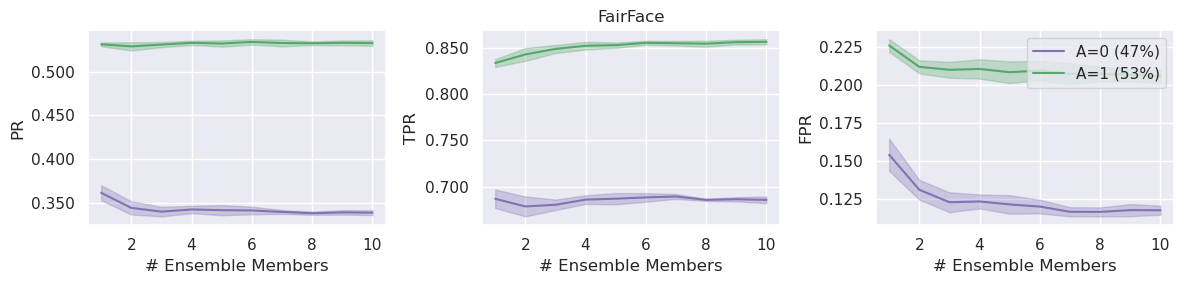

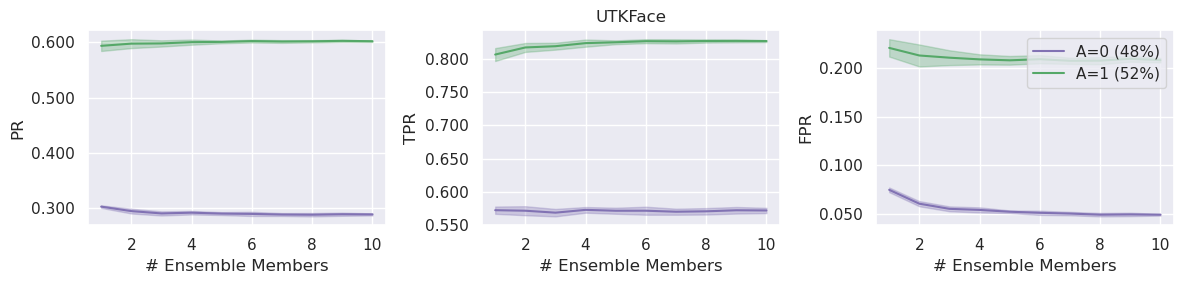

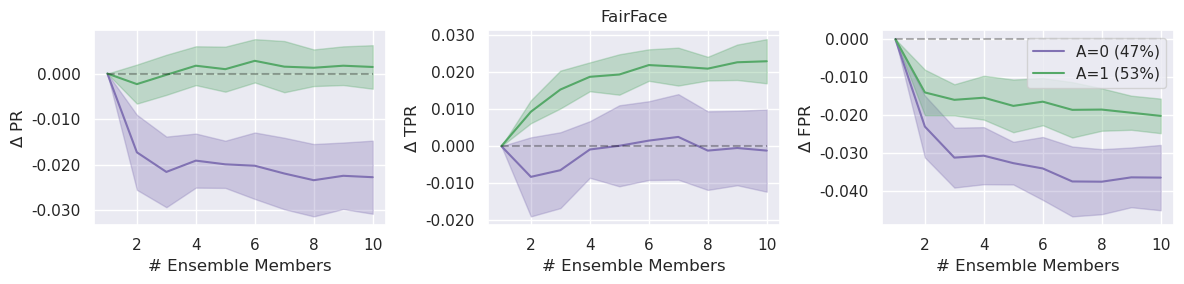

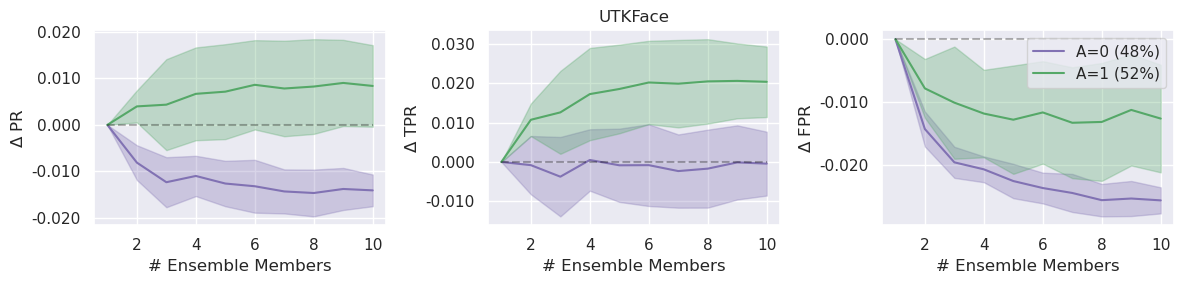

In [40]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

for delta in [False, True]:

    ff_test_fm_prs_1, ff_test_fm_prs_0 = list(), list()
    ff_test_fm_tprs_1, ff_test_fm_tprs_0 = list(), list()
    ff_test_fm_fprs_1, ff_test_fm_fprs_0 = list(), list()
    utk_test_fm_prs_1, utk_test_fm_prs_0 = list(), list()
    utk_test_fm_tprs_1, utk_test_fm_tprs_0 = list(), list()
    utk_test_fm_fprs_1, utk_test_fm_fprs_0 = list(), list()

    for m in range(len(method_seeds)):

        ff_test_fm_prs_1_, ff_test_fm_prs_0_ = list(), list()
        ff_test_fm_tprs_1_, ff_test_fm_tprs_0_ = list(), list()
        ff_test_fm_fprs_1_, ff_test_fm_fprs_0_ = list(), list()
        utk_test_fm_prs_1_, utk_test_fm_prs_0_ = list(), list()
        utk_test_fm_tprs_1_, utk_test_fm_tprs_0_ = list(), list()
        utk_test_fm_fprs_1_, utk_test_fm_fprs_0_ = list(), list()

        for em in ensemble_members:
            preds = torch.mean(ff_test_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_ff_test_t)
            tpr1, tpr0 = get_tprs(preds, y_ff_test_t, a_ff_test_t)
            fpr1, fpr0 = get_fprs(preds, y_ff_test_t, a_ff_test_t)
            ff_test_fm_prs_1_.append(pr1)
            ff_test_fm_prs_0_.append(pr0)
            ff_test_fm_tprs_1_.append(tpr1)
            ff_test_fm_tprs_0_.append(tpr0)
            ff_test_fm_fprs_1_.append(fpr1)
            ff_test_fm_fprs_0_.append(fpr0)

            preds = torch.mean(utk_test_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_utk_test_t)
            tpr1, tpr0 = get_tprs(preds, y_utk_test_t, a_utk_test_t)
            fpr1, fpr0 = get_fprs(preds, y_utk_test_t, a_utk_test_t)
            utk_test_fm_prs_1_.append(pr1)
            utk_test_fm_prs_0_.append(pr0)
            utk_test_fm_tprs_1_.append(tpr1)
            utk_test_fm_tprs_0_.append(tpr0)
            utk_test_fm_fprs_1_.append(fpr1)
            utk_test_fm_fprs_0_.append(fpr0)
            
        if delta:
            ff_test_fm_prs_1.append([t - ff_test_fm_prs_1_[0] for t in ff_test_fm_prs_1_])
            ff_test_fm_prs_0.append([t - ff_test_fm_prs_0_[0] for t in ff_test_fm_prs_0_])
            ff_test_fm_tprs_1.append([t - ff_test_fm_tprs_1_[0] for t in ff_test_fm_tprs_1_])
            ff_test_fm_tprs_0.append([t - ff_test_fm_tprs_0_[0] for t in ff_test_fm_tprs_0_])
            ff_test_fm_fprs_1.append([t - ff_test_fm_fprs_1_[0] for t in ff_test_fm_fprs_1_])
            ff_test_fm_fprs_0.append([t - ff_test_fm_fprs_0_[0] for t in ff_test_fm_fprs_0_])

            utk_test_fm_prs_1.append([t - utk_test_fm_prs_1_[0] for t in utk_test_fm_prs_1_])
            utk_test_fm_prs_0.append([t - utk_test_fm_prs_0_[0] for t in utk_test_fm_prs_0_])
            utk_test_fm_tprs_1.append([t - utk_test_fm_tprs_1_[0] for t in utk_test_fm_tprs_1_])
            utk_test_fm_tprs_0.append([t - utk_test_fm_tprs_0_[0] for t in utk_test_fm_tprs_0_])
            utk_test_fm_fprs_1.append([t - utk_test_fm_fprs_1_[0] for t in utk_test_fm_fprs_1_])
            utk_test_fm_fprs_0.append([t - utk_test_fm_fprs_0_[0] for t in utk_test_fm_fprs_0_])
        else:
            ff_test_fm_prs_1.append(ff_test_fm_prs_1_)
            ff_test_fm_prs_0.append(ff_test_fm_prs_0_)
            ff_test_fm_tprs_1.append(ff_test_fm_tprs_1_)
            ff_test_fm_tprs_0.append(ff_test_fm_tprs_0_)
            ff_test_fm_fprs_1.append(ff_test_fm_fprs_1_)
            ff_test_fm_fprs_0.append(ff_test_fm_fprs_0_)

            utk_test_fm_prs_1.append(utk_test_fm_prs_1_)
            utk_test_fm_prs_0.append(utk_test_fm_prs_0_)
            utk_test_fm_tprs_1.append(utk_test_fm_tprs_1_)
            utk_test_fm_tprs_0.append(utk_test_fm_tprs_0_)
            utk_test_fm_fprs_1.append(utk_test_fm_fprs_1_)
            utk_test_fm_fprs_0.append(utk_test_fm_fprs_0_)

    ff_test_fm_prs_1 = np.asarray(ff_test_fm_prs_1)
    ff_test_fm_prs_0 = np.asarray(ff_test_fm_prs_0)
    ff_test_fm_tprs_1 = np.asarray(ff_test_fm_tprs_1)
    ff_test_fm_tprs_0 = np.asarray(ff_test_fm_tprs_0)
    ff_test_fm_fprs_1 = np.asarray(ff_test_fm_fprs_1)
    ff_test_fm_fprs_0 = np.asarray(ff_test_fm_fprs_0)

    utk_test_fm_prs_1 = np.asarray(utk_test_fm_prs_1)
    utk_test_fm_prs_0 = np.asarray(utk_test_fm_prs_0)
    utk_test_fm_tprs_1 = np.asarray(utk_test_fm_tprs_1)
    utk_test_fm_tprs_0 = np.asarray(utk_test_fm_tprs_0)
    utk_test_fm_fprs_1 = np.asarray(utk_test_fm_fprs_1)
    utk_test_fm_fprs_0 = np.asarray(utk_test_fm_fprs_0)

    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([ff_test_fm_prs_0, ff_test_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("$\Delta$ PR" if delta else "PR")
    for t, test_tpr in enumerate([ff_test_fm_tprs_0, ff_test_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_tpr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[1].fill_between(ensemble_members,
                            np.mean(test_tpr, axis=0) - np.std(test_tpr, axis=0), 
                            np.mean(test_tpr, axis=0) + np.std(test_tpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("$\Delta$ TPR" if delta else "TPR")
    for t, test_fpr in enumerate([ff_test_fm_fprs_0, ff_test_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_fpr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[2].fill_between(ensemble_members,
                            np.mean(test_fpr, axis=0) - np.std(test_fpr, axis=0), 
                            np.mean(test_fpr, axis=0) + np.std(test_fpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("$\Delta$ FPR" if delta else "FPR")
    axs[2].legend(loc="upper right")

    axs[1].set_title("FairFace")


    for i, ax in enumerate(axs.flatten()):
        # ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_delta_rates_ff.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_rates_ff.pdf"))
    plt.show()



    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([utk_test_fm_prs_0, utk_test_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("$\Delta$ PR" if delta else "PR")
    for t, test_tpr in enumerate([utk_test_fm_tprs_0, utk_test_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_tpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[1].fill_between(ensemble_members,
                            np.mean(test_tpr, axis=0) - np.std(test_tpr, axis=0), 
                            np.mean(test_tpr, axis=0) + np.std(test_tpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("$\Delta$ TPR" if delta else "TPR")
    for t, test_fpr in enumerate([utk_test_fm_fprs_0, utk_test_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_fpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[2].fill_between(ensemble_members,
                            np.mean(test_fpr, axis=0) - np.std(test_fpr, axis=0), 
                            np.mean(test_fpr, axis=0) + np.std(test_fpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("$\Delta$ FPR" if delta else "FPR")
    axs[2].legend(loc="upper right")

    axs[1].set_title("UTKFace")


    for i, ax in enumerate(axs.flatten()):
        # ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_delta_rates_utk.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_rates_utk.pdf"))
    plt.show()

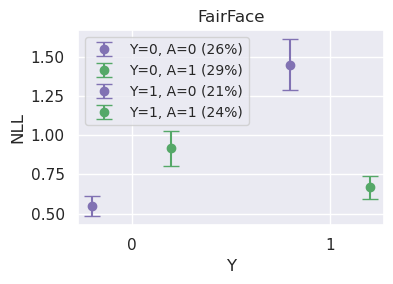

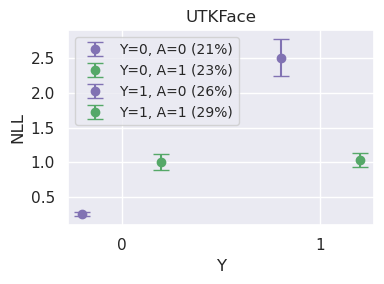

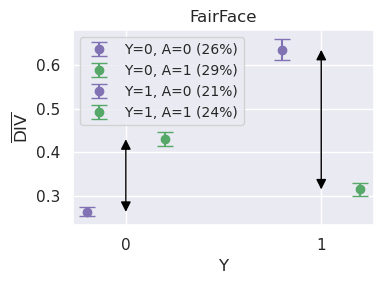

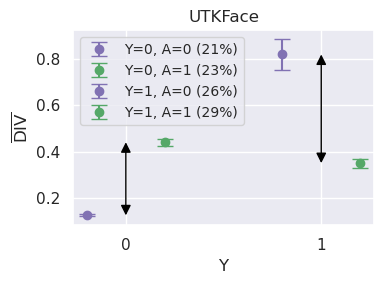

In [41]:
ff_test_member_loss_y0_a1, ff_test_member_loss_y1_a1, ff_test_member_loss_y0_a0, ff_test_member_loss_y1_a0 = list(), list(), list(), list()
ff_test_member_loss_a1, ff_test_member_loss_a0 = list(), list()
ff_test_ensemble_loss_y0_a1, ff_test_ensemble_loss_y1_a1, ff_test_ensemble_loss_y0_a0, ff_test_ensemble_loss_y1_a0 = list(), list(), list(), list()
ff_test_ensemble_loss_a1, ff_test_ensemble_loss_a0 = list(), list()
utk_test_member_loss_y0_a1, utk_test_member_loss_y1_a1, utk_test_member_loss_y0_a0, utk_test_member_loss_y1_a0 = list(), list(), list(), list()
utk_test_member_loss_a1, utk_test_member_loss_a0 = list(), list()
utk_test_ensemble_loss_y0_a1, utk_test_ensemble_loss_y1_a1, utk_test_ensemble_loss_y0_a0, utk_test_ensemble_loss_y1_a0 = list(), list(), list(), list()
utk_test_ensemble_loss_a1, utk_test_ensemble_loss_a0 = list(), list()

preds = torch.stack(ff_test_probits)
member_loss = - torch.log(torch.gather(preds, dim=3, index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])))[..., 0]

ff_test_member_loss_y1_a1 = member_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_y0_a1 = member_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_y1_a0 = member_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_y0_a0 = member_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_a1 = member_loss[..., a_ff_test_t == 1].mean(dim=2).reshape(1, -1)
ff_test_member_loss_a0 = member_loss[..., a_ff_test_t == 0].mean(dim=2).reshape(1, -1)

S, M, N, P = preds.shape
# m_preds = torch.mean(preds.reshape(S * M, N, P), keepdim=True, dim=0)
# ensemble_loss = - torch.log(torch.gather(m_preds, dim=2, 
#                                          index=y_ff_test_t.reshape(1, -1, 1).expand_as(m_preds[..., :1])))[0][..., 0]
ensemble_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3,
                                            index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0] 
ff_test_ensemble_loss_y1_a1 = ensemble_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_y0_a1 = ensemble_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_y1_a0 = ensemble_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_y0_a0 = ensemble_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_a1 = ensemble_loss[..., a_ff_test_t == 1].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_a0 = ensemble_loss[..., a_ff_test_t == 0].mean(dim=1).reshape(1, -1)

preds = torch.stack(utk_test_probits)
member_loss = - torch.log(torch.gather(preds, dim=3, index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])))[..., 0]

utk_test_member_loss_y1_a1 = member_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_y0_a1 = member_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_y1_a0 = member_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_y0_a0 = member_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_a1 = member_loss[..., a_utk_test_t == 1].mean(dim=2).reshape(1, -1)
utk_test_member_loss_a0 = member_loss[..., a_utk_test_t == 0].mean(dim=2).reshape(1, -1)

S, M, N, P = preds.shape
# m_preds = torch.mean(preds.reshape(S * M, N, P), keepdim=True, dim=0)
# ensemble_loss = - torch.log(torch.gather(m_preds, dim=2,
#                                         index=y_utk_test_t.reshape(1, -1, 1).expand_as(m_preds[..., :1])))[0][..., 0]
ensemble_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3,
                                            index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]       
utk_test_ensemble_loss_y1_a1 = ensemble_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_y0_a1 = ensemble_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_y1_a0 = ensemble_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_y0_a0 = ensemble_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_a1 = ensemble_loss[..., a_utk_test_t == 1].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_a0 = ensemble_loss[..., a_utk_test_t == 0].mean(dim=1).reshape(1, -1)

#### YA difference

plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([ff_test_member_loss_y0_a0, ff_test_member_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
for t, test_ent in enumerate([ff_test_member_loss_y1_a0, ff_test_member_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
# for t, test_ent in enumerate([ff_test_ensemble_loss_y0_a0, ff_test_ensemble_loss_y0_a1]):
#     plt.scatter([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
# for t, test_ent in enumerate([ff_test_ensemble_loss_y1_a0, ff_test_ensemble_loss_y1_a1]):
#     plt.scatter([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
plt.title("FairFace")
plt.ylabel("NLL")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)") for t in range(2)])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ya_ff.pdf"))
plt.show()


plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([utk_test_member_loss_y0_a0, utk_test_member_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
for t, test_ent in enumerate([utk_test_member_loss_y1_a0, utk_test_member_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
# for t, test_ent in enumerate([utk_test_ensemble_loss_y0_a0, utk_test_ensemble_loss_y0_a1]):
#     plt.scatter([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
# for t, test_ent in enumerate([utk_test_ensemble_loss_y1_a0, utk_test_ensemble_loss_y1_a1]):
#     plt.scatter([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
plt.title("UTKFace")
plt.ylabel("NLL")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ya_utk.pdf"))
plt.show()


# YA difference

ff_test_member_loss_y0_a0 = torch.mean(ff_test_member_loss_y0_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
ff_test_member_loss_y0_a1 = torch.mean(ff_test_member_loss_y0_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
ff_test_member_loss_y1_a0 = torch.mean(ff_test_member_loss_y1_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
ff_test_member_loss_y1_a1 = torch.mean(ff_test_member_loss_y1_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y0_a0 = torch.mean(utk_test_member_loss_y0_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y0_a1 = torch.mean(utk_test_member_loss_y0_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y1_a0 = torch.mean(utk_test_member_loss_y1_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y1_a1 = torch.mean(utk_test_member_loss_y1_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)

plt.figure(figsize=(4, 3))

test_ents_y0 = [ff_test_member_loss_y0_a0 - ff_test_ensemble_loss_y0_a0, ff_test_member_loss_y0_a1 - ff_test_ensemble_loss_y0_a1]
for t, test_ent in enumerate(test_ents_y0):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
test_ents_y1 = [ff_test_member_loss_y1_a0 - ff_test_ensemble_loss_y1_a0, ff_test_member_loss_y1_a1 - ff_test_ensemble_loss_y1_a1]
for t, test_ent in enumerate(test_ents_y1):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
ylims = plt.gca().get_ylim()
arrow = patches.FancyArrowPatch((0, torch.mean(test_ents_y0[1][0], dim=0)), 
                                (0, torch.mean(test_ents_y0[0][0], dim=0)), 
                                arrowstyle='<|-|>', 
                                color='black', 
                                mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
arrow = patches.FancyArrowPatch((1, torch.mean(test_ents_y1[1][0], dim=0)), 
                                (1, torch.mean(test_ents_y1[0][0], dim=0)), 
                                arrowstyle='<|-|>', 
                                color='black', 
                                mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
plt.ylim(ylims)
plt.title("FairFace")
plt.ylabel("$\\overline{\mathrm{DIV}}$")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)") for t in range(2)])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ratio_ya_ff.pdf"))
plt.show()


plt.figure(figsize=(4, 3))

test_ents_y0 = [utk_test_member_loss_y0_a0 - utk_test_ensemble_loss_y0_a0, utk_test_member_loss_y0_a1 - utk_test_ensemble_loss_y0_a1]
for t, test_ent in enumerate(test_ents_y0):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
test_ents_y1 = [utk_test_member_loss_y1_a0 - utk_test_ensemble_loss_y1_a0, utk_test_member_loss_y1_a1 - utk_test_ensemble_loss_y1_a1]
for t, test_ent in enumerate(test_ents_y1):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
ylims = plt.gca().get_ylim()
arrow = patches.FancyArrowPatch((0, torch.mean(test_ents_y0[1][0], dim=0)), 
                                (0, torch.mean(test_ents_y0[0][0], dim=0)), 
                                arrowstyle='<|-|>', 
                                color='black', 
                                mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
arrow = patches.FancyArrowPatch((1, torch.mean(test_ents_y1[1][0], dim=0)), 
                                (1, torch.mean(test_ents_y1[0][0], dim=0)), 
                                arrowstyle='<|-|>', 
                                color='black', 
                                mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
plt.ylim(ylims)
plt.title("UTKFace")
plt.ylabel("$\\overline{\mathrm{DIV}}$")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ratio_ya_utk.pdf"))
plt.show()

# Weighting

In [42]:
# select the best temperature on validation set
temperatures = np.logspace(2, -6, 300)

optim_temps_spd, optim_temps_eod, optim_temps_aod = list(), list(), list()

for m in range(len(method_seeds)):

    best_temp_spd, best_temp_eod, best_temp_aod = temperatures[0], temperatures[0], temperatures[0]
    best_spd, best_eod, best_aod = float("inf"), float("inf"), float("inf")

    for temperature in temperatures:
    
        preds = torch.sum(val_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / temperature, dim=0).reshape(-1, 1, 1), 
                        dim=0).argmax(dim=1)
        if np.abs(spd(preds, a_val_t)) < np.abs(best_spd):
            best_spd = spd(preds, a_val_t)
            best_temp_spd = temperature
        preds = torch.sum(val_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
        if np.abs(eod(preds, y_val_t, a_val_t)) < np.abs(best_eod):
            best_eod = eod(preds, y_val_t, a_val_t)
            best_temp_eod = temperature
        preds = torch.sum(val_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
        if np.abs(aod(preds, y_val_t, a_val_t)) < np.abs(best_aod):
            best_aod = aod(preds, y_val_t, a_val_t)
            best_temp_aod = temperature
    
    optim_temps_spd.append(best_temp_spd)
    optim_temps_eod.append(best_temp_eod)
    optim_temps_aod.append(best_temp_aod)

In [43]:
ff_test_fm_spd_accs, utk_test_fm_spd_accs = list(), list()
ff_test_fm_spds, utk_test_fm_spds = list(), list()
ff_test_fm_eod_accs, utk_test_fm_eod_accs = list(), list()
ff_test_fm_eods, utk_test_fm_eods = list(), list()
ff_test_fm_aod_accs, utk_test_fm_aod_accs = list(), list()
ff_test_fm_aods, utk_test_fm_aods = list(), list()

for m in range(len(method_seeds)):
    preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / optim_temps_spd[m], dim=0).reshape(-1, 1, 1), 
                      dim=0).argmax(dim=1)
    ff_test_fm_spd_accs.append(accuracy(preds, y_ff_test_t))
    ff_test_fm_spds.append(spd(preds, a_ff_test_t))
    preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / optim_temps_eod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    ff_test_fm_eod_accs.append(accuracy(preds, y_ff_test_t))
    ff_test_fm_eods.append(eod(preds, y_ff_test_t, a_ff_test_t))
    preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / optim_temps_aod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    ff_test_fm_aod_accs.append(accuracy(preds, y_ff_test_t))
    ff_test_fm_aods.append(aod(preds, y_ff_test_t, a_ff_test_t))

    preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / optim_temps_spd[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    utk_test_fm_spd_accs.append(accuracy(preds, y_utk_test_t))
    utk_test_fm_spds.append(spd(preds, a_utk_test_t))
    preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / optim_temps_eod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    utk_test_fm_eod_accs.append(accuracy(preds, y_utk_test_t))
    utk_test_fm_eods.append(eod(preds, y_utk_test_t, a_utk_test_t))
    preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / optim_temps_aod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    utk_test_fm_aod_accs.append(accuracy(preds, y_utk_test_t))
    utk_test_fm_aods.append(aod(preds, y_utk_test_t, a_utk_test_t))

In [44]:
print("#" * 80)
print(f"FairFace Test Set | Target: {targets[target]} | Protected Attribute: {targets[pa]}")
print("#" * 80)

# Individual models
# only first model per seed
print("Individual Models:")
print(f"Accuracy: Mean = {np.mean(np.asarray(ff_test_accs)[:, 0] * 100):.2f}, Std = {np.std(np.asarray(ff_test_accs)[:, 0] * 100):.2f}")
print(f"SPD: Mean = {np.mean(np.asarray(ff_test_spds)[:, 0]):.4f}, Std = {np.std(np.asarray(ff_test_spds)[:, 0]):.4f}")
print(f"EOD: Mean = {np.mean(np.asarray(ff_test_eods)[:, 0]):.4f}, Std = {np.std(np.asarray(ff_test_eods)[:, 0]):.4f}")
print(f"AOD: Mean = {np.mean(np.asarray(ff_test_aods)[:, 0]):.4f}, Std = {np.std(np.asarray(ff_test_aods)[:, 0]):.4f}")
print("-" * 80)

# all models over all seeds
print("Individual Models (all):")
print(f"Accuracy: Mean = {np.mean(np.asarray(ff_test_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(ff_test_spds):.4f}, Std = {np.std(ff_test_spds):.4f}")
print(f"EOD: Mean = {np.mean(ff_test_eods):.4f}, Std = {np.std(ff_test_eods):.4f}")
print(f"AOD: Mean = {np.mean(ff_test_aods):.4f}, Std = {np.std(ff_test_aods):.4f}")
print("-" * 80)

# Fairest model on Fairness dataset
print("Fairest Model (on Fairness Dataset):")
fairest_acc_spd = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(ff_test_spds)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(ff_test_eods)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(ff_test_aods)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
fairest_acc_spd = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(ff_test_spds)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(ff_test_eods)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(ff_test_aods)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# BMA
print("Uniform Average:")
print(f"Accuracy: Mean = {np.mean(np.asarray(ff_test_m_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_m_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(ff_test_m_spds):.4f}, Std = {np.std(ff_test_m_spds):.4f}")
print(f"EOD: Mean = {np.mean(ff_test_m_eods):.4f}, Std = {np.std(ff_test_m_eods):.4f}")
print(f"AOD: Mean = {np.mean(ff_test_m_aods):.4f}, Std = {np.std(ff_test_m_aods):.4f}")
print("-" * 80)

# Tempered average
print("Fairness Weighted Average:")
print(f"Accuracy (SPD): Mean = {np.mean(np.asarray(ff_test_fm_spd_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_fm_spd_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(ff_test_fm_spds):.4f}, Std = {np.std(ff_test_fm_spds):.4f}")
print(f"Accuracy (EOD): Mean = {np.mean(np.asarray(ff_test_fm_eod_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_fm_eod_accs) * 100):.2f}")
print(f"EOD: Mean = {np.mean(ff_test_fm_eods):.4f}, Std = {np.std(ff_test_fm_eods):.4f}")
print(f"Accuracy (AOD): Mean = {np.mean(np.asarray(ff_test_fm_aod_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_fm_aod_accs) * 100):.2f}")
print(f"AOD: Mean = {np.mean(ff_test_fm_aods):.4f}, Std = {np.std(ff_test_fm_aods):.4f}")
print("-" * 80)

################################################################################
FairFace Test Set | Target: age | Protected Attribute: gender
################################################################################
Individual Models:
Accuracy: Mean = 79.47, Std = 0.45
SPD: Mean = 0.1701, Std = 0.0079
EOD: Mean = 0.1467, Std = 0.0103
AOD: Mean = 0.1093, Std = 0.0076
--------------------------------------------------------------------------------
Individual Models (all):
Accuracy: Mean = 79.43, Std = 0.30
SPD: Mean = 0.1728, Std = 0.0070
EOD: Mean = 0.1534, Std = 0.0121
AOD: Mean = 0.1126, Std = 0.0076
--------------------------------------------------------------------------------
Fairest Model (on Fairness Dataset):
Accuracy (SPD): Mean = 79.43, Std = 0.32
SPD: Mean = 0.1711, Std = 0.0069
Accuracy (EOD): Mean = 79.42, Std = 0.27
EOD: Mean = 0.1493, Std = 0.0097
Accuracy (AOD): Mean = 79.39, Std = 0.31
AOD: Mean = 0.1102, Std = 0.0081
-------------------------------------------

In [45]:
print("#" * 80)
print(f"UTK Test Set | Target: {targets[target]} | Protected Attribute: {targets[pa]}")
print("#" * 80)

# Individual models
# only first model per seed
print("Individual Models:")
print(f"Accuracy: Mean = {np.mean(np.asarray(utk_test_accs)[:, 0] * 100):.2f}, Std = {np.std(np.asarray(utk_test_accs)[:, 0] * 100):.2f}")
print(f"SPD: Mean = {np.mean(np.asarray(utk_test_spds)[:, 0]):.4f}, Std = {np.std(np.asarray(utk_test_spds)[:, 0]):.4f}")
print(f"EOD: Mean = {np.mean(np.asarray(utk_test_eods)[:, 0]):.4f}, Std = {np.std(np.asarray(utk_test_eods)[:, 0]):.4f}")
print(f"AOD: Mean = {np.mean(np.asarray(utk_test_aods)[:, 0]):.4f}, Std = {np.std(np.asarray(utk_test_aods)[:, 0]):.4f}")
print("-" * 80)

# all models over all seeds
print("Individual Models (all):")
print(f"Accuracy: Mean = {np.mean(np.asarray(utk_test_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(utk_test_spds):.4f}, Std = {np.std(utk_test_spds):.4f}")
print(f"EOD: Mean = {np.mean(utk_test_eods):.4f}, Std = {np.std(utk_test_eods):.4f}")
print(f"AOD: Mean = {np.mean(utk_test_aods):.4f}, Std = {np.std(utk_test_aods):.4f}")
print("-" * 80)

# Fairest model on Fairness dataset
print("Fairest Model (on Fairness Dataset):")
fairest_acc_spd = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(utk_test_spds)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(utk_test_eods)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(utk_test_aods)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
fairest_acc_spd = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(utk_test_spds)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(utk_test_eods)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(utk_test_aods)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# BMA
print("Uniform Average:")
print(f"Accuracy: Mean = {np.mean(np.asarray(utk_test_m_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_m_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(utk_test_m_spds):.4f}, Std = {np.std(utk_test_m_spds):.4f}")
print(f"EOD: Mean = {np.mean(utk_test_m_eods):.4f}, Std = {np.std(utk_test_m_eods):.4f}")
print(f"AOD: Mean = {np.mean(utk_test_m_aods):.4f}, Std = {np.std(utk_test_m_aods):.4f}")
print("-" * 80)

# Tempered average
print("Fairness Weighted Average:")
print(f"Accuracy (SPD): Mean = {np.mean(np.asarray(utk_test_fm_spd_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_fm_spd_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(utk_test_fm_spds):.4f}, Std = {np.std(utk_test_fm_spds):.4f}")
print(f"Accuracy (EOD): Mean = {np.mean(np.asarray(utk_test_fm_eod_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_fm_eod_accs) * 100):.2f}")
print(f"EOD: Mean = {np.mean(utk_test_fm_eods):.4f}, Std = {np.std(utk_test_fm_eods):.4f}")
print(f"Accuracy (AOD): Mean = {np.mean(np.asarray(utk_test_fm_aod_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_fm_aod_accs) * 100):.2f}")
print(f"AOD: Mean = {np.mean(utk_test_fm_aods):.4f}, Std = {np.std(utk_test_fm_aods):.4f}")
print("-" * 80)

################################################################################
UTK Test Set | Target: age | Protected Attribute: gender
################################################################################
Individual Models:
Accuracy: Mean = 78.07, Std = 0.28
SPD: Mean = 0.2908, Std = 0.0076
EOD: Mean = 0.2345, Std = 0.0067
AOD: Mean = 0.1903, Std = 0.0073
--------------------------------------------------------------------------------
Individual Models (all):
Accuracy: Mean = 78.15, Std = 0.38
SPD: Mean = 0.2961, Std = 0.0080
EOD: Mean = 0.2401, Std = 0.0117
AOD: Mean = 0.1954, Std = 0.0085
--------------------------------------------------------------------------------
Fairest Model (on Fairness Dataset):
Accuracy (SPD): Mean = 78.16, Std = 0.36
SPD: Mean = 0.2967, Std = 0.0077
Accuracy (EOD): Mean = 78.14, Std = 0.36
EOD: Mean = 0.2416, Std = 0.0105
Accuracy (AOD): Mean = 78.12, Std = 0.38
AOD: Mean = 0.1975, Std = 0.0069
------------------------------------------------